# Лабораторная работа № 2.
Обучение сверточной нейронной сети ResNet18 с применением трансферного обучения
и аугментации данных.

# Цель работы
Получить классификации изображений с помощью сверточных нейронных сетей с применением трансферного обучения и аугментации данных с использованием библиотеки машинного обучения PyTorch.
# Задачи
1. Ознакомиться с работой сверточных нейронных сетей в библиотеке PyTorch;
2. Научиться решать задачу классификации изображений на основе нейронных сетей.
3. Научиться применять методы трансферного обучения с использованием библиотеки PyTorch.
4. Научиться применять методы аугментации данных с использованием библиотеки PyTorch.

# Немного теории

## Сверточные нейронные сети


### Сверточные слои (convolution layer)
Сверточные нейросети — это модель глубокого обучения, один из видов искусственных нейросетей. В ёё основе — математическая операция свертки.
**Двумерная свертка (2D convolution)** — это довольно простая операция: начинаем с ядра, представляющего из себя матрицу весов (weight matrix). Ядро “скользит” над двумерным изображением, поэлементно выполняя операцию умножения с той частью входных данных, над которой оно сейчас находится, и затем суммирует все полученные значения в один выходной пиксель.
Алгоритм работы операции двумерной свертки представлен на gif:

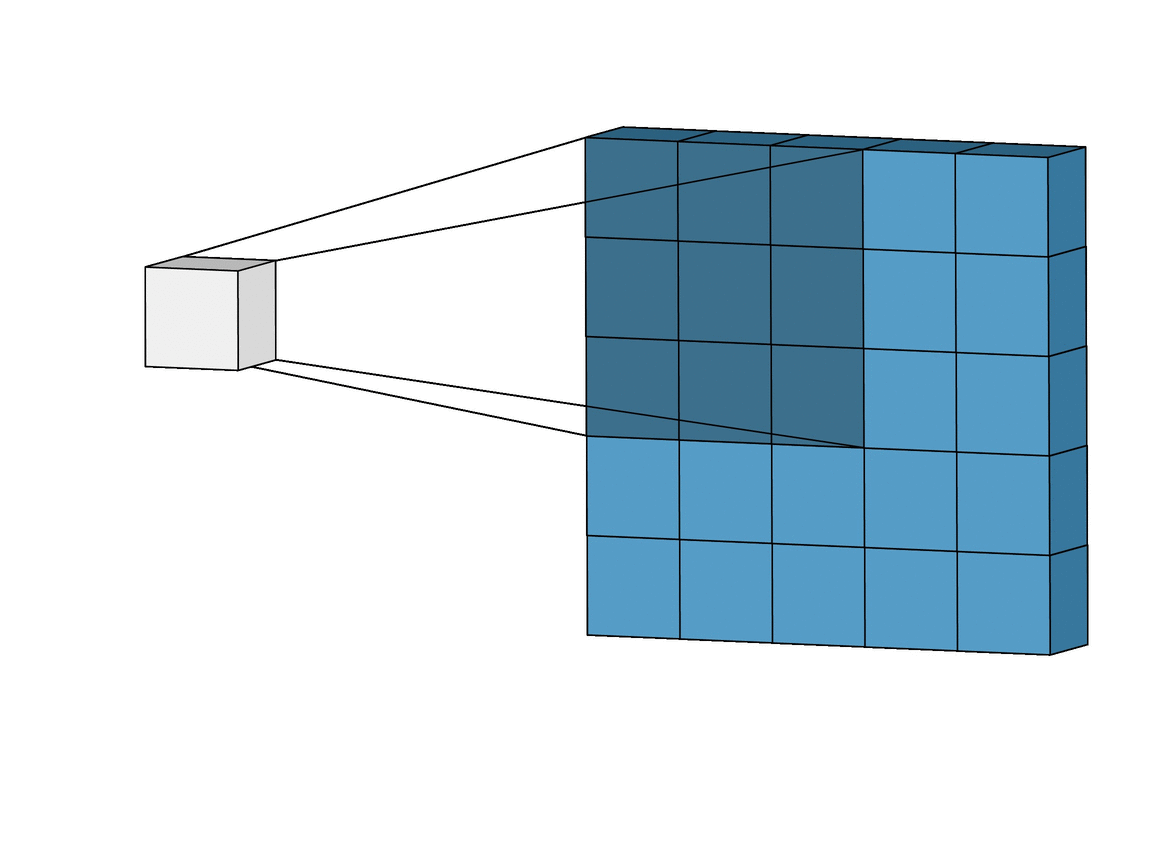

Такой способ извлечения признаков позволяет:

1.   Сократить количество обучаемых параметров. Например на приведенной выше gif мы имеем 5*5=25 признаков на входе и 3*3=9 признаков на выходе. Для стандартного слоя (standard fully connected layer) мы бы имели весовую матрицу 25*9 = 225 параметров, а каждый выходной признак являлся бы взвешенной суммой всех признаков на входе. Свертка позволяет произвести такую операцию с всего 9-ю параметрами
2.    Во время свёртки нейросеть удаляет лишнее и оставляет полезное — то, что поможет проанализировать изображение. Например, линии, края или ровные области.

У свертки есть несколько важных параметров (из [документации](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) PyTorch):


*   in_channels (int) – количество входных каналов
*   out_channels (int) – количество выходных каналов
*   kernel_size (int or tuple) – размер окна ядра свертки
*   padding (int, tuple or str, optional) – добавляет к краям поддельные (fake) пиксели (обычно нулевого значения, вследствие этого к ним применяется термин “нулевое дополнение” — “zero padding”). Таким образом, ядро при проскальзывании позволяет неподдельным пикселям оказываться в своем центре, а затем распространяется на поддельные пиксели за пределами края, создавая выходную матрицу того же размера, что и входная.



### Слои пуллинга (pooling layer)

После свёрточного слоя идёт слой пулинга. Из признаков, которые выделил свёрточный слой, выбирает самые важные, а несущественные удаляет. К результату, который получился во время пулинга, можно снова применить свёрточный слой и сделать несколько циклов. Это нужно, чтобы выстроить иерархию признаков: от самых примитивных, например кусочков контура, до более сложных, например глаз кошки или формы её ушей.

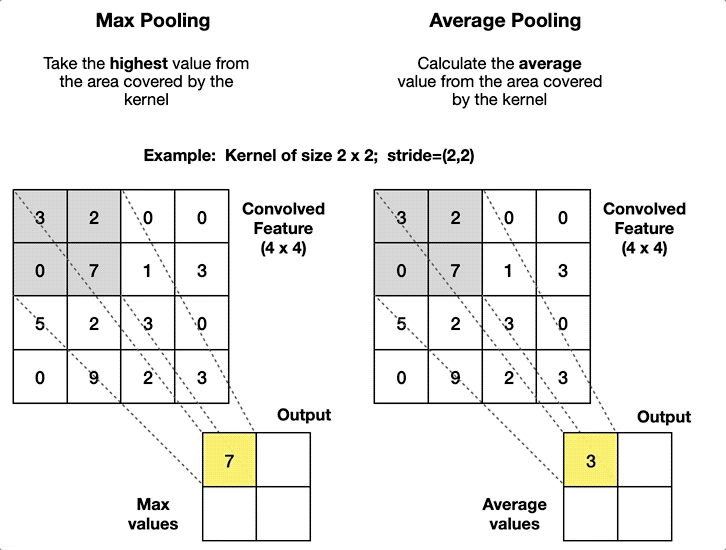

### Пара примеров, как нейросеть извлекает признаки из изображений

Первые слои нейросети. Здесь она ищет границы объектов по перепадам света. Пример от Adit Deshpande

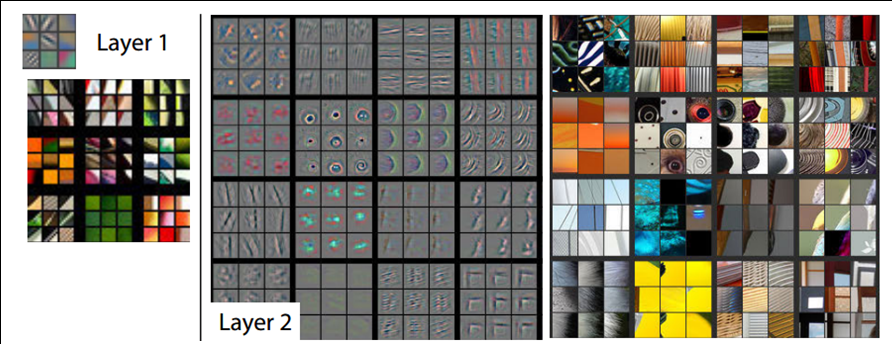

На последних слоях нейросеть пытается понять, что или кто перед ней. Например, есть что-то похожее на колёса. Возможно, на фотографии велосипед. Но это не точно, поэтому альтернативный вариант — глаза птиц.

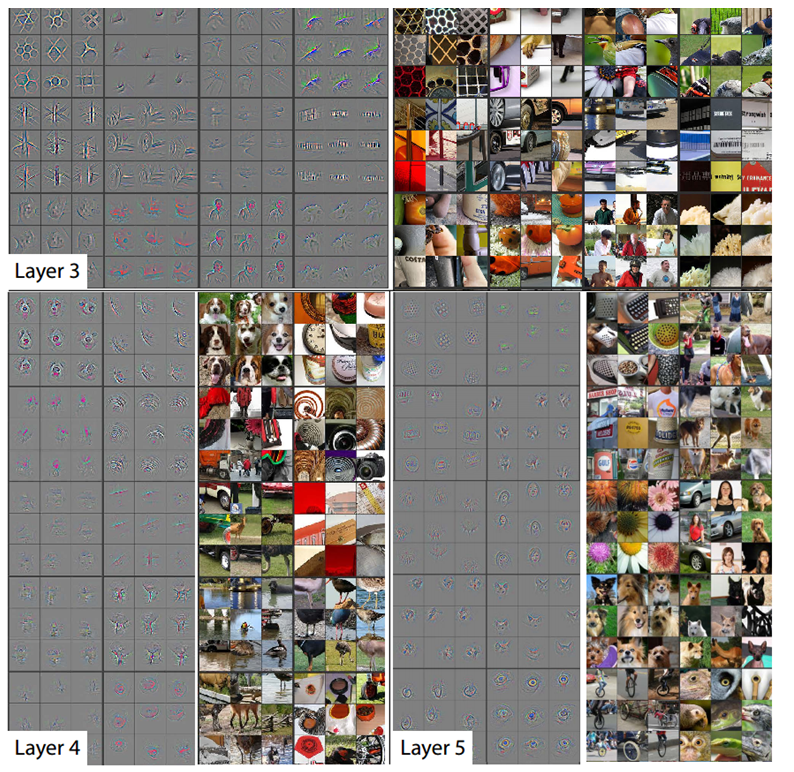

Сложные признаки, которые получились на последних слоях, нейросеть будет классифицировать с помощью полносвязного слоя, чтобы найти ответ на вопрос, что изображено на картинке, сова или кошка.

## Собираем все в нейросеть


Нагляднее всего архитектуру свёрточной нейросети можно показать примере — ResNet.

**ResNet (Residual Network)** является одной из самых популярных сверточных нейросетей. Она была представлена в 2015 году и быстро стала одной из наиболее используемых нейросетей в области компьютерного зрения.

ResNet смогла преодолеть одну из основных проблем нейросетей - затухание градиента, которая возникает, когда градиенты начинают сходиться к нулю, что приводит к уменьшению скорости обучения и качества модели.

Одним из основных преимуществ ResNet является то, что она может обрабатывать глубокие нейросети, что позволяет достичь более высоких показателей точности в области распознавания изображений.

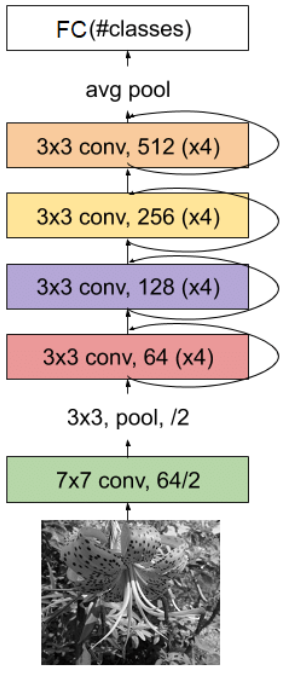


ResNet состоит из нескольких типовых шагов с типовыми операциями: свёртка и пулинг. Однако у ResNet есть особенность: после серии свёрточных блоков следуют несколько полносвязных слоёв. Это стандартный подход для задач классификации изображений.

# Начало

In [ ]:
# установка API
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

# создаем директорию kaggle и копируем файл в нее,
# добавляя разрешение на запись и чтение
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
# скачиваем сет
!kaggle competitions download -c platesv2

Saving kaggle.json to kaggle.json
 96% 45.0M/47.0M [00:03<00:00, 20.5MB/s]
100% 47.0M/47.0M [00:03<00:00, 12.7MB/s]


In [ ]:
%%capture
# распаковка сета
!unzip platesv2.zip
!unzip plates.zip

In [ ]:
# удаляем лишнее
!rm platesv2.zip

# Сеть ResNet18

Для начала попробуем обучить ResNet18 без применения особых техник (трансферное обучение и аугментация). Вдруг и так заработает?



## Подготовка датасета

Разархивируем датасет из zip файла при помощи библиотки `zipfile` в текущую директорию. Вместо `your_path_to_files` укажите свой путь к файлам.

In [ ]:
import numpy as np # линейная алгебра
import pandas as pd # обрадобтка табличных данных (csv и т.д.)

import os

import shutil
from tqdm import tqdm

import torch
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
data_root = 'plates/'
print(os.listdir(data_root))

['test', 'train', '.DS_Store']


Как можно увидеть выше данные разбиты на две папки: train и test. Однако нам бы хотелось во вермя обучения проверять как наша модель ведет себя на не виденных ее раньше данных. Для этого разобьем часть датасета для обучения еще на 2 части: обучающую и валидационную. Валидационная часть нужна как раз для того, чтобы проверять модель на новых для нее данных.

In [ ]:
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
      """
      Переводим каждый шестой пример в папку с валидацией
      """
      if i % 6 != 0:
          dest_dir = os.path.join(train_dir, class_name)
      else:
          dest_dir = os.path.join(val_dir, class_name)
      shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 3042.08it/s]


In [ ]:
def create_sub(test_img_paths, test_predictions, name='submission'):
    submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
    submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
    submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
    submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
    submission_df.set_index('id', inplace=True)

    submission_df.to_csv(f'{name}.csv')

    return submission_df

# вывод изображения

Создадим итератор `torch.utils.data.DataLoader` для получения изображений из папок и их меток (к какому классу относится изображение). Итератор возвращает изображения в формате PIL *(Python Image Library)*, поэтому к изображениям необходимо применить преобразования для приведения их к нужному формату.

**Задание**: Создайте итератор для получения изображение из папки с валидационными изображениями.

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # привдение к нужному размеру
    transforms.ToTensor(), # перевод изображения в pytorch tensor
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 2
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

Выведем первое изображение из обучающей выборки.

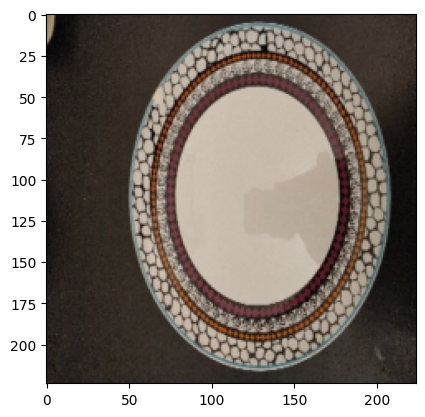

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))
plt.imshow(X_batch[0].permute(1, 2, 0).numpy());

Создадим функцию для вывода изображений

**Задание**: Выведите все изображения в первом батче при помощи функции show_input.

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def show_input(input_tensor, norm=False, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    if norm:
      image1 = std * image + mean
      plt.imshow(image1.clip(0, 1))
    else:
      plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

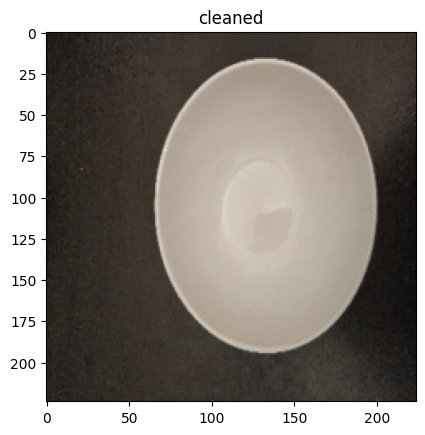

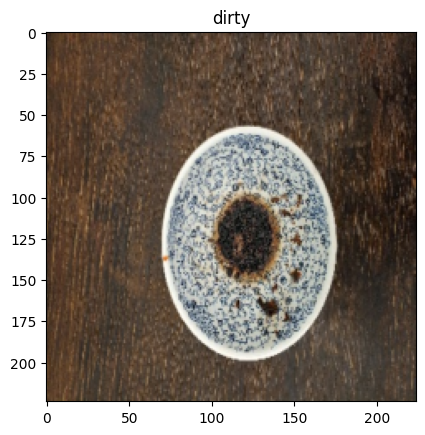

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    # реализованная выше функция show_input
    show_input(x_item, title=class_names[y_item])

Реализуем функцию для обучения модели.
Функция работает по следующему алгоритму:

* В фазе обучения
  1.   Загрузка тренирововчных данных при помощи `DataLoader`
  2.   Вычисление прямого распространения сигнала по сети
  3.   Вычисление значение функции ошибки
  4.   Вычисление градиентов
  5.   Изменение весовых параметров сети
* В фазе валидации
  1.   Загрузка валидационных данных при помощи `DataLoader`
  2.   Вычисление прямого распространения сигнала по сети
  3.   Вычисление значение функции ошибки

# train_model

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):

    train_loss = torch.zeros(num_epochs)
    val_loss = torch.zeros(num_epochs)
    train_acc = torch.zeros(num_epochs)
    val_acc = torch.zeros(num_epochs)

    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Каждую эпоху происходят тренировочные и валидационные фазы
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step() # !!!
                model.train()  # Переводим модель в режим train
            else:
                dataloader = val_dataloader
                # Переводим модель в режим eval, чтобы параметр модели не изменялись
                model.eval()

            running_loss = 0.
            running_acc = 0.

            # Загружаем входные данные
            for inputs, labels in tqdm(dataloader):
                # Переносим данные на видеокарту
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Выполняем прямой проход по сети и вычисляем значение функции ошибки
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # обратное распространение + изменение параметров
                    # (только в фазу train)
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # собираем статистики
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'train':
                train_loss[epoch] = epoch_loss
                train_acc[epoch] = epoch_acc
            else:
                val_loss[epoch] = epoch_loss
                val_acc[epoch] = epoch_acc

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    train_loss = train_loss.numpy()
    val_loss = val_loss.numpy()
    train_acc = train_acc.numpy()
    val_acc = val_acc.numpy()

    # немного графиков, необязательно
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')


    plt.subplot(2, 1, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

    return train_loss, val_loss, train_acc, val_acc

## Подготовка модели ResNet18

Для начала создадим модель сети. Так как данная модель уже реализована в библиотеке `torchvision` просто импортируем ее из модуля `torchvision.models`.
В библиотеке реализованы только слои со свертками и пуллингами, поэтому нам необходимо добавить полносвязный слой, который и будет производить классификацию.

In [ ]:
# Создание модели
model1 = models.resnet18()

# Добавляем в конец модели полносвязный слой
model1.fc = torch.nn.Linear(model1.fc.in_features, 2)

# Переносим параметры модели на GPU
model1 = model1.to(device)

# Задаем функцию потерь и оптимизатор
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1.0e-3)

# Уменьшает шаг градиентоного спуска каждую седьмую эпоху
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

<span style="color:red">!!! Обратите внимание на количество обучаемых параметров !!!</span>

In [ ]:
num_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 11,177,538 trainable parameters


## Обучение

Epoch 0/49:


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

train Loss: 1.1832 Acc: 0.5625



100%|██████████| 4/4 [00:00<00:00, 21.12it/s]

val Loss: 3.0634 Acc: 0.5000


Epoch 1/49:


100%|██████████| 16/16 [00:00<00:00, 36.54it/s]

train Loss: 0.9206 Acc: 0.4688



100%|██████████| 4/4 [00:00<00:00, 20.80it/s]


val Loss: 1.1000 Acc: 0.5000
Epoch 2/49:


100%|██████████| 16/16 [00:00<00:00, 37.01it/s]

train Loss: 0.7636 Acc: 0.5625



100%|██████████| 4/4 [00:00<00:00, 22.66it/s]

val Loss: 0.8445 Acc: 0.3750
Epoch 3/49:



100%|██████████| 16/16 [00:00<00:00, 31.95it/s]

train Loss: 0.7666 Acc: 0.4062



100%|██████████| 4/4 [00:00<00:00, 14.48it/s]

val Loss: 0.8038 Acc: 0.3750
Epoch 4/49:



100%|██████████| 16/16 [00:00<00:00, 23.70it/s]

train Loss: 0.7702 Acc: 0.4375



100%|██████████| 4/4 [00:00<00:00, 14.00it/s]

val Loss: 0.7848 Acc: 0.2500
Epoch 5/49:



100%|██████████| 16/16 [00:00<00:00, 23.66it/s]

train Loss: 0.8510 Acc: 0.4062



100%|██████████| 4/4 [00:00<00:00, 13.85it/s]

val Loss: 0.7986 Acc: 0.6250
Epoch 6/49:



100%|██████████| 16/16 [00:00<00:00, 25.55it/s]

train Loss: 0.7678 Acc: 0.5000



100%|██████████| 4/4 [00:00<00:00, 14.74it/s]

val Loss: 0.8503 Acc: 0.5000
Epoch 7/49:



100%|██████████| 16/16 [00:00<00:00, 27.04it/s]

train Loss: 0.7649 Acc: 0.4375



100%|██████████| 4/4 [00:00<00:00, 21.54it/s]

val Loss: 0.8150 Acc: 0.1250
Epoch 8/49:



100%|██████████| 16/16 [00:00<00:00, 36.83it/s]

train Loss: 0.6711 Acc: 0.6250



100%|██████████| 4/4 [00:00<00:00, 10.05it/s]

val Loss: 0.8259 Acc: 0.1250
Epoch 9/49:



100%|██████████| 16/16 [00:00<00:00, 24.60it/s]

train Loss: 0.6604 Acc: 0.6562



100%|██████████| 4/4 [00:00<00:00, 22.91it/s]

val Loss: 0.8205 Acc: 0.1250
Epoch 10/49:



100%|██████████| 16/16 [00:00<00:00, 36.75it/s]

train Loss: 0.6522 Acc: 0.6250



100%|██████████| 4/4 [00:00<00:00, 22.04it/s]

val Loss: 0.8070 Acc: 0.1250
Epoch 11/49:



100%|██████████| 16/16 [00:00<00:00, 36.17it/s]

train Loss: 0.6322 Acc: 0.7500



100%|██████████| 4/4 [00:00<00:00, 21.68it/s]

val Loss: 0.8704 Acc: 0.1250


Epoch 12/49:


100%|██████████| 16/16 [00:00<00:00, 35.78it/s]

train Loss: 0.6209 Acc: 0.6562



100%|██████████| 4/4 [00:00<00:00, 22.71it/s]

val Loss: 0.8588 Acc: 0.3750
Epoch 13/49:



100%|██████████| 16/16 [00:00<00:00, 35.65it/s]

train Loss: 0.6412 Acc: 0.5625



100%|██████████| 4/4 [00:00<00:00, 21.33it/s]


val Loss: 0.8468 Acc: 0.3750
Epoch 14/49:


100%|██████████| 16/16 [00:00<00:00, 34.87it/s]

train Loss: 0.6427 Acc: 0.6250



100%|██████████| 4/4 [00:00<00:00, 23.09it/s]

val Loss: 0.8320 Acc: 0.3750
Epoch 15/49:



100%|██████████| 16/16 [00:00<00:00, 34.38it/s]

train Loss: 0.6853 Acc: 0.5312



100%|██████████| 4/4 [00:00<00:00, 20.88it/s]

val Loss: 0.8629 Acc: 0.3750
Epoch 16/49:



100%|██████████| 16/16 [00:00<00:00, 35.95it/s]

train Loss: 0.6108 Acc: 0.7188



100%|██████████| 4/4 [00:00<00:00, 22.44it/s]

val Loss: 0.8227 Acc: 0.3750
Epoch 17/49:



100%|██████████| 16/16 [00:00<00:00, 26.70it/s]

train Loss: 0.5996 Acc: 0.6250



100%|██████████| 4/4 [00:00<00:00, 16.54it/s]

val Loss: 0.8493 Acc: 0.3750
Epoch 18/49:



100%|██████████| 16/16 [00:00<00:00, 35.49it/s]

train Loss: 0.5830 Acc: 0.7188



100%|██████████| 4/4 [00:00<00:00, 21.62it/s]

val Loss: 0.8434 Acc: 0.3750


Epoch 19/49:


100%|██████████| 16/16 [00:00<00:00, 36.68it/s]

train Loss: 0.6157 Acc: 0.5938



100%|██████████| 4/4 [00:00<00:00, 22.32it/s]

val Loss: 0.8511 Acc: 0.2500
Epoch 20/49:



100%|██████████| 16/16 [00:00<00:00, 35.02it/s]

train Loss: 0.6061 Acc: 0.6562



100%|██████████| 4/4 [00:00<00:00, 21.72it/s]

val Loss: 0.8385 Acc: 0.2500


Epoch 21/49:


100%|██████████| 16/16 [00:00<00:00, 35.52it/s]

train Loss: 0.6254 Acc: 0.6562



100%|██████████| 4/4 [00:00<00:00,  8.15it/s]

val Loss: 0.8058 Acc: 0.5000
Epoch 22/49:



100%|██████████| 16/16 [00:01<00:00, 10.19it/s]

train Loss: 0.6267 Acc: 0.6562



100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

val Loss: 0.8368 Acc: 0.2500
Epoch 23/49:



100%|██████████| 16/16 [00:00<00:00, 23.57it/s]

train Loss: 0.6593 Acc: 0.6250



100%|██████████| 4/4 [00:00<00:00, 14.40it/s]

val Loss: 0.8545 Acc: 0.2500
Epoch 24/49:



100%|██████████| 16/16 [00:00<00:00, 28.85it/s]

train Loss: 0.6121 Acc: 0.7188



100%|██████████| 4/4 [00:00<00:00, 22.33it/s]

val Loss: 0.8458 Acc: 0.2500
Epoch 25/49:



100%|██████████| 16/16 [00:00<00:00, 36.20it/s]

train Loss: 0.6183 Acc: 0.6875



100%|██████████| 4/4 [00:00<00:00, 21.07it/s]

val Loss: 0.8228 Acc: 0.3750
Epoch 26/49:



100%|██████████| 16/16 [00:00<00:00, 35.96it/s]

train Loss: 0.5779 Acc: 0.6875



100%|██████████| 4/4 [00:00<00:00, 21.85it/s]

val Loss: 0.8248 Acc: 0.2500


Epoch 27/49:


100%|██████████| 16/16 [00:00<00:00, 34.98it/s]

train Loss: 0.6080 Acc: 0.6562



100%|██████████| 4/4 [00:00<00:00, 22.44it/s]

val Loss: 0.8203 Acc: 0.5000
Epoch 28/49:



100%|██████████| 16/16 [00:00<00:00, 36.67it/s]

train Loss: 0.6288 Acc: 0.6562



100%|██████████| 4/4 [00:00<00:00, 22.71it/s]

val Loss: 0.8213 Acc: 0.3750
Epoch 29/49:



100%|██████████| 16/16 [00:00<00:00, 36.10it/s]

train Loss: 0.5953 Acc: 0.7188



100%|██████████| 4/4 [00:00<00:00, 21.97it/s]

val Loss: 0.8041 Acc: 0.3750


Epoch 30/49:


100%|██████████| 16/16 [00:00<00:00, 36.26it/s]

train Loss: 0.6479 Acc: 0.6562



100%|██████████| 4/4 [00:00<00:00, 19.56it/s]

val Loss: 0.8360 Acc: 0.3750
Epoch 31/49:



100%|██████████| 16/16 [00:00<00:00, 35.97it/s]

train Loss: 0.6178 Acc: 0.7188



100%|██████████| 4/4 [00:00<00:00, 21.40it/s]

val Loss: 0.8571 Acc: 0.2500


Epoch 32/49:


100%|██████████| 16/16 [00:00<00:00, 35.84it/s]

train Loss: 0.6727 Acc: 0.5312



100%|██████████| 4/4 [00:00<00:00, 21.92it/s]

val Loss: 0.8230 Acc: 0.3750
Epoch 33/49:



100%|██████████| 16/16 [00:00<00:00, 36.94it/s]

train Loss: 0.5865 Acc: 0.7188



100%|██████████| 4/4 [00:00<00:00, 21.81it/s]

val Loss: 0.8193 Acc: 0.3750
Epoch 34/49:



100%|██████████| 16/16 [00:00<00:00, 36.43it/s]

train Loss: 0.5771 Acc: 0.7812



100%|██████████| 4/4 [00:00<00:00, 22.64it/s]

val Loss: 0.8462 Acc: 0.2500
Epoch 35/49:



100%|██████████| 16/16 [00:00<00:00, 35.77it/s]

train Loss: 0.5919 Acc: 0.7188



100%|██████████| 4/4 [00:00<00:00, 22.14it/s]

val Loss: 0.8376 Acc: 0.2500


Epoch 36/49:


100%|██████████| 16/16 [00:00<00:00, 35.72it/s]

train Loss: 0.6354 Acc: 0.5312



100%|██████████| 4/4 [00:00<00:00, 21.92it/s]

val Loss: 0.8285 Acc: 0.2500


Epoch 37/49:


100%|██████████| 16/16 [00:00<00:00, 34.41it/s]

train Loss: 0.6209 Acc: 0.7188



100%|██████████| 4/4 [00:00<00:00, 21.53it/s]

val Loss: 0.8087 Acc: 0.2500


Epoch 38/49:


100%|██████████| 16/16 [00:00<00:00, 34.90it/s]

train Loss: 0.5678 Acc: 0.7812



100%|██████████| 4/4 [00:00<00:00, 21.17it/s]

val Loss: 0.8025 Acc: 0.3750
Epoch 39/49:



100%|██████████| 16/16 [00:00<00:00, 30.49it/s]

train Loss: 0.6008 Acc: 0.6250



100%|██████████| 4/4 [00:00<00:00, 12.39it/s]

val Loss: 0.8361 Acc: 0.2500
Epoch 40/49:



100%|██████████| 16/16 [00:00<00:00, 22.77it/s]

train Loss: 0.6286 Acc: 0.5938



100%|██████████| 4/4 [00:00<00:00, 12.23it/s]

val Loss: 0.8140 Acc: 0.2500
Epoch 41/49:



100%|██████████| 16/16 [00:00<00:00, 24.16it/s]

train Loss: 0.6114 Acc: 0.6250



100%|██████████| 4/4 [00:00<00:00, 12.64it/s]

val Loss: 0.8193 Acc: 0.2500
Epoch 42/49:



100%|██████████| 16/16 [00:00<00:00, 24.32it/s]

train Loss: 0.6661 Acc: 0.5312



100%|██████████| 4/4 [00:00<00:00, 14.94it/s]

val Loss: 0.8445 Acc: 0.2500
Epoch 43/49:



100%|██████████| 16/16 [00:00<00:00, 28.55it/s]

train Loss: 0.6234 Acc: 0.6250



100%|██████████| 4/4 [00:00<00:00, 21.37it/s]


val Loss: 0.8241 Acc: 0.3750
Epoch 44/49:


100%|██████████| 16/16 [00:00<00:00, 35.05it/s]

train Loss: 0.5994 Acc: 0.6250



100%|██████████| 4/4 [00:00<00:00, 21.39it/s]


val Loss: 0.8102 Acc: 0.2500
Epoch 45/49:


100%|██████████| 16/16 [00:00<00:00, 35.23it/s]

train Loss: 0.6478 Acc: 0.6562



100%|██████████| 4/4 [00:00<00:00, 22.52it/s]

val Loss: 0.8393 Acc: 0.3750


Epoch 46/49:


100%|██████████| 16/16 [00:00<00:00, 34.84it/s]

train Loss: 0.6188 Acc: 0.5312



100%|██████████| 4/4 [00:00<00:00, 22.41it/s]

val Loss: 0.8399 Acc: 0.2500


Epoch 47/49:


100%|██████████| 16/16 [00:00<00:00, 34.36it/s]

train Loss: 0.6145 Acc: 0.7500



100%|██████████| 4/4 [00:00<00:00, 20.87it/s]

val Loss: 0.8236 Acc: 0.2500


Epoch 48/49:


100%|██████████| 16/16 [00:00<00:00, 35.84it/s]

train Loss: 0.6248 Acc: 0.7188



100%|██████████| 4/4 [00:00<00:00, 21.05it/s]

val Loss: 0.8339 Acc: 0.2500
Epoch 49/49:



100%|██████████| 16/16 [00:00<00:00, 34.04it/s]

train Loss: 0.6547 Acc: 0.5000



100%|██████████| 4/4 [00:00<00:00, 22.39it/s]

val Loss: 0.8296 Acc: 0.3750


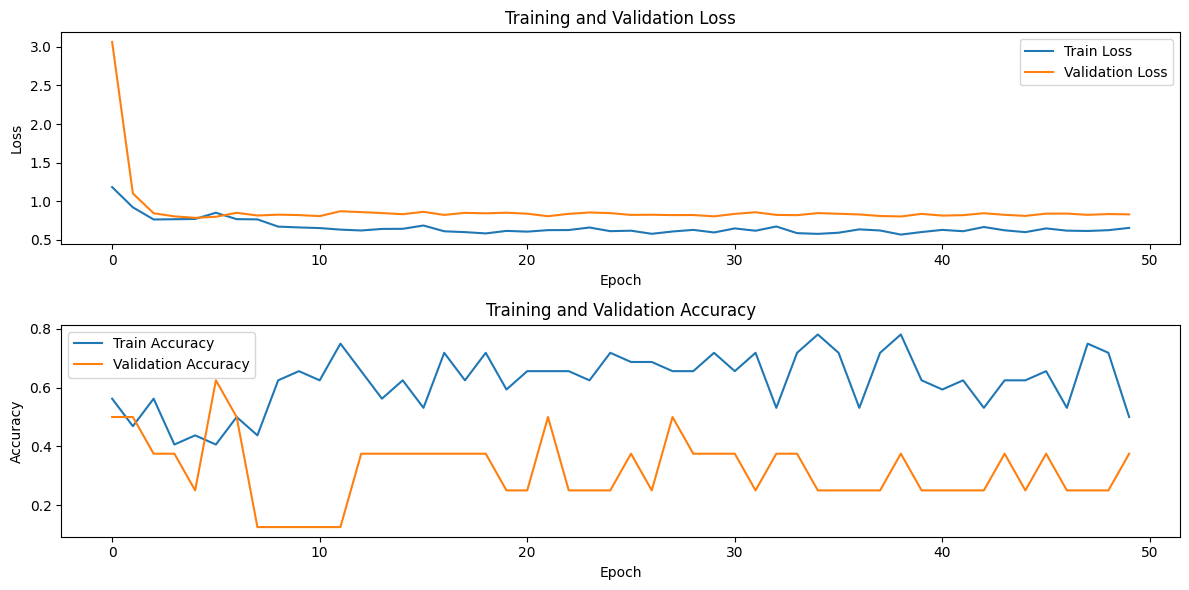

In [ ]:
train_loss, val_loss, train_acc, val_acc = train_model(model1, loss, optimizer, scheduler, num_epochs=50);

## Проверяем на тестовой выборке

Так как класс `ImageFolder` принимает на вход путь, где лежат папки, в которых нанаходятся изображения определенного класса, то для загрузки тестового датасета необходимо скопировать изображения в папке `test`  в папку `test/unknown`, чтобы загружчик работал корректно.

In [ ]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

Также, чтобы корректно сформировать файл, который потом будет загружен на Kaggle, нам необходимо получить пути к изображениям. Для этого был создан класс `ImageFolderWithPaths`, который возвращает не только изображения и метки, но еще и пути к изображениям.

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
test_dataset = ImageFolderWithPaths('test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

**Задание**: Вычислите финальную точность сети на обучающем наборе данных

In [ ]:
def get_acc(model, dataloader):
    clf = model
    clf.eval()  # режим оценки

    correct_predictions = 0
    total_samples = 0

    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            preds = clf(inputs)

        # Получим предсказания в виде индексов классов
        _, predicted_labels = torch.max(preds, 1)

        # Подсчитаем количество правильных предсказаний
        correct_predictions += (predicted_labels == labels).sum().item()

        # Общее количество образцов
        total_samples += labels.size(0)

    # Вычисление финальной точности
    final_accuracy = correct_predictions / total_samples

    print(f'Финальная точность сети на обучающем наборе данных: {final_accuracy * 100:.2f}%')

In [ ]:
get_acc(model1, val_dataloader)

100%|██████████| 4/4 [00:00<00:00, 20.97it/s]

Финальная точность сети на обучающем наборе данных: 37.50%


Вычислим предсказания сети для тестовой выборки

In [ ]:
def get_pred(model, dataloader):
    clf = model
    clf.eval()  # режим оценки

    test_predictions = []
    test_img_paths = []

    for inputs, labels, paths in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            preds = clf(inputs)
        test_predictions.append(
            torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
        test_img_paths.extend(paths)

    test_predictions = np.concatenate(test_predictions)

    return test_predictions, test_img_paths

In [ ]:
test_predictions, test_img_paths = get_pred(model1, test_dataloader)

100%|██████████| 372/372 [00:03<00:00, 95.02it/s]


Посмотрим, что получилось

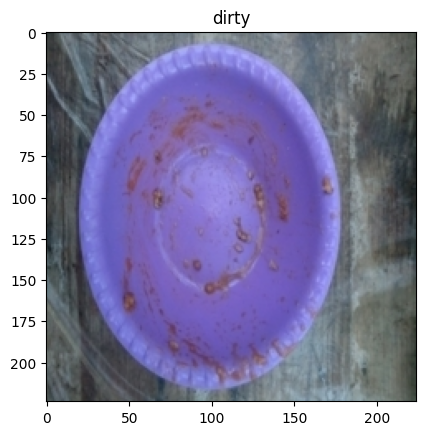

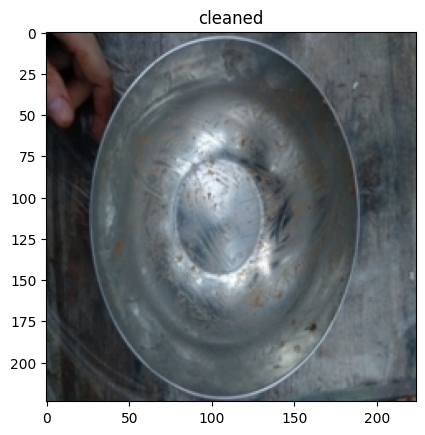

In [ ]:
inputs, labels, paths = next(iter(test_dataloader))
func = lambda pred: 'dirty' if pred > 0.5 else 'cleaned'

for img, pred in zip(inputs, test_predictions):
  show_input(img, title=func(pred))

Для того, чтобы получить финальную точность на тестовой выборке необходимо загрузить файл submission.csv на сайт Kaggle. Для этого необходимо пеерйти на [страницу соревнования](https://www.kaggle.com/competitions/platesv2/data). URL: https://www.kaggle.com/competitions/platesv2/data.
Далее нажать кнопку Submit Predictions и выгрузить файл. После этого система вычислит и покажет вам финальную точность.

В следующих ячейках происходит сохранение предсказаний модели в CSV файл.

In [ ]:
submission_df = create_sub(test_img_paths, test_predictions, 'bad_submission')
submission_df.head()

<ipython-input-28-7b759809f8b5>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_df['id'] = submission_df['id'].str.replace('.jpg', '')


label
id           
0000  cleaned
0001    dirty
0002  cleaned
0003    dirty
0004    dirty

In [ ]:
# делаю сабмит сразу
!kaggle competitions submit -c platesv2 -f bad_submission.csv -m "Message"

100% 8.58k/8.58k [00:00<00:00, 30.5kB/s]
Successfully submitted to Cleaned vs Dirty V2

**Задание**: Напишите здесь, какая у вас получилась точность -

**0.67876**

0.44623

Если ваша точность составила более 0.6, то вы счастливчик)

Неужели все настолько безнадежно? Конечно же нет!

Применим первую технику: **трансферное обучение**.

# **Сеть ResNet18 с применением трансферного обучения**

Главная идея трансферного обучения заключается в том, чтобы взять заранее обученную на другом наборе данных модель и дообучить ее для своей задачи. При этом не обязательно обучать все слои сети, так как в предобученной моделе начальные слои уже умеют хорошо выделять необходимые признаки из изображений.

Transfer learning эффективнее на порядок по сравнению со случайной инициализацией, потому что вам только нужно оптимизировать параметры конечного полностью связанного слоя, а это означает, что вы можете иметь фантастическую производительность всего лишь с несколькими десятками изображений в классе.

В основном код остается неизменным, за исключением нескольких моментов. В библиотеке `torchvision` модель ResNet18 была предобучена на наборе данных [IMAGENET1K](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html), и перед обучением изображения данного датасета были преодобработаны. Чтобы наша сеть также хорошо выделяла признаки из наших данных необходимо их нормализовать аналогичным образом. Для этого к преобразованиям изображений была добавлена трансформация нормировки: `transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])`.

## Подготовка датасета

**Задание**: Создайте итератор для получения изображение из папки с валидационными изображениями.

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 2

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

**Задание**: Выведите все изображения первого батча.

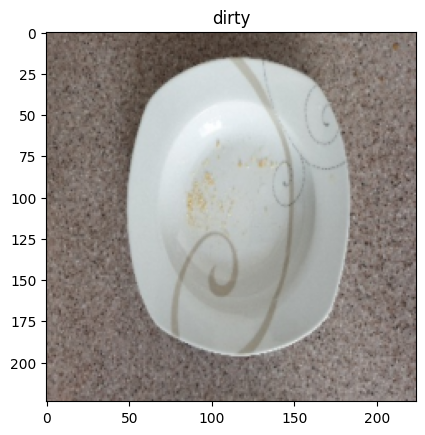

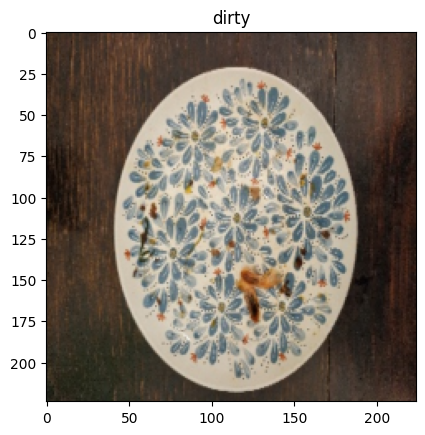

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, True, title=class_names[y_item])

## Подготовка предобученной модели ResNet18

Для того, чтобы загрузить предобученную модель модель необходимо указать параметр `pretrained=True`.

Также для того, чтобы не обучать всю модель полностью мы отключим возможность обучения всех слоев сети, кроме полносвязного слоя.

**Задание**: Определите функцию потерь и оптимизатор

In [ ]:
model2 = models.resnet18(pretrained=True)

# Отключение возможности расчета градиентов у всех слоев загруженной сети
for param in model2.parameters():
    param.requires_grad = False

model2.fc = torch.nn.Linear(model2.fc.in_features, 2)

model2 = model2.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1.0e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 91.6MB/s]


Обратите внимаение, что количество обучаемых параметров уменьшилось

In [ ]:
num_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 1,026 trainable parameters


## Обучение

Epoch 0/49:


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 16/16 [00:00<00:00, 47.62it/s]

train Loss: 0.9322 Acc: 0.4688



100%|██████████| 4/4 [00:00<00:00, 20.60it/s]

val Loss: 1.1042 Acc: 0.1250


Epoch 1/49:


100%|██████████| 16/16 [00:00<00:00, 46.36it/s]

train Loss: 0.9030 Acc: 0.4375



100%|██████████| 4/4 [00:00<00:00, 19.94it/s]

val Loss: 1.0638 Acc: 0.1250
Epoch 2/49:



100%|██████████| 16/16 [00:00<00:00, 47.90it/s]

train Loss: 0.7511 Acc: 0.4062



100%|██████████| 4/4 [00:00<00:00, 19.38it/s]

val Loss: 1.0892 Acc: 0.2500
Epoch 3/49:



100%|██████████| 16/16 [00:00<00:00, 35.47it/s]

train Loss: 0.6838 Acc: 0.6562



100%|██████████| 4/4 [00:00<00:00, 12.99it/s]

val Loss: 0.9872 Acc: 0.3750
Epoch 4/49:



100%|██████████| 16/16 [00:00<00:00, 27.12it/s]

train Loss: 0.7253 Acc: 0.5312



100%|██████████| 4/4 [00:00<00:00, 12.07it/s]

val Loss: 0.9613 Acc: 0.3750
Epoch 5/49:



100%|██████████| 16/16 [00:00<00:00, 27.68it/s]

train Loss: 0.8318 Acc: 0.4062



100%|██████████| 4/4 [00:00<00:00, 12.23it/s]

val Loss: 0.9850 Acc: 0.6250
Epoch 6/49:



100%|██████████| 16/16 [00:00<00:00, 29.67it/s]

train Loss: 0.6995 Acc: 0.5312



100%|██████████| 4/4 [00:00<00:00, 12.97it/s]

val Loss: 0.9426 Acc: 0.5000
Epoch 7/49:



100%|██████████| 16/16 [00:00<00:00, 31.50it/s]

train Loss: 0.6326 Acc: 0.6562



100%|██████████| 4/4 [00:00<00:00, 19.90it/s]

val Loss: 0.8968 Acc: 0.3750
Epoch 8/49:



100%|██████████| 16/16 [00:00<00:00, 48.33it/s]

train Loss: 0.6295 Acc: 0.6250



100%|██████████| 4/4 [00:00<00:00, 20.25it/s]

val Loss: 0.8637 Acc: 0.5000


Epoch 9/49:


100%|██████████| 16/16 [00:00<00:00, 46.87it/s]

train Loss: 0.6251 Acc: 0.7500



100%|██████████| 4/4 [00:00<00:00, 18.20it/s]

val Loss: 0.8127 Acc: 0.5000
Epoch 10/49:



100%|██████████| 16/16 [00:00<00:00, 47.04it/s]

train Loss: 0.5901 Acc: 0.7812



100%|██████████| 4/4 [00:00<00:00, 18.29it/s]

val Loss: 0.8199 Acc: 0.5000
Epoch 11/49:



100%|██████████| 16/16 [00:00<00:00, 47.03it/s]

train Loss: 0.6590 Acc: 0.6875



100%|██████████| 4/4 [00:00<00:00, 19.16it/s]

val Loss: 0.8010 Acc: 0.5000
Epoch 12/49:



100%|██████████| 16/16 [00:00<00:00, 47.89it/s]

train Loss: 0.6730 Acc: 0.6562



100%|██████████| 4/4 [00:00<00:00, 19.73it/s]

val Loss: 0.8504 Acc: 0.3750
Epoch 13/49:



100%|██████████| 16/16 [00:00<00:00, 46.54it/s]

train Loss: 0.6589 Acc: 0.5938



100%|██████████| 4/4 [00:00<00:00, 20.13it/s]

val Loss: 0.8162 Acc: 0.5000
Epoch 14/49:



100%|██████████| 16/16 [00:00<00:00, 47.03it/s]

train Loss: 0.6302 Acc: 0.6562



100%|██████████| 4/4 [00:00<00:00, 19.91it/s]

val Loss: 0.8190 Acc: 0.5000
Epoch 15/49:



100%|██████████| 16/16 [00:00<00:00, 46.95it/s]

train Loss: 0.5683 Acc: 0.7500



100%|██████████| 4/4 [00:00<00:00, 20.39it/s]

val Loss: 0.8400 Acc: 0.5000
Epoch 16/49:



100%|██████████| 16/16 [00:00<00:00, 49.03it/s]

train Loss: 0.5630 Acc: 0.7812



100%|██████████| 4/4 [00:00<00:00, 19.14it/s]

val Loss: 0.8397 Acc: 0.5000
Epoch 17/49:



100%|██████████| 16/16 [00:00<00:00, 43.00it/s]

train Loss: 0.6557 Acc: 0.5938



100%|██████████| 4/4 [00:00<00:00, 20.34it/s]


val Loss: 0.8168 Acc: 0.5000
Epoch 18/49:


100%|██████████| 16/16 [00:00<00:00, 48.91it/s]

train Loss: 0.6318 Acc: 0.7188



100%|██████████| 4/4 [00:00<00:00, 19.32it/s]

val Loss: 0.8544 Acc: 0.5000
Epoch 19/49:



100%|██████████| 16/16 [00:00<00:00, 49.41it/s]

train Loss: 0.5886 Acc: 0.7188



100%|██████████| 4/4 [00:00<00:00, 19.77it/s]

val Loss: 0.8616 Acc: 0.5000
Epoch 20/49:



100%|██████████| 16/16 [00:00<00:00, 47.52it/s]

train Loss: 0.7119 Acc: 0.5625



100%|██████████| 4/4 [00:00<00:00, 20.26it/s]

val Loss: 0.8486 Acc: 0.5000


Epoch 21/49:


100%|██████████| 16/16 [00:00<00:00, 47.72it/s]

train Loss: 0.6010 Acc: 0.6562



100%|██████████| 4/4 [00:00<00:00, 20.17it/s]

val Loss: 0.8437 Acc: 0.5000


Epoch 22/49:


100%|██████████| 16/16 [00:00<00:00, 47.68it/s]

train Loss: 0.6480 Acc: 0.6562



100%|██████████| 4/4 [00:00<00:00, 20.39it/s]

val Loss: 0.8573 Acc: 0.5000


Epoch 23/49:


100%|██████████| 16/16 [00:00<00:00, 48.80it/s]

train Loss: 0.5301 Acc: 0.8750



100%|██████████| 4/4 [00:00<00:00, 19.36it/s]

val Loss: 0.8321 Acc: 0.5000
Epoch 24/49:



100%|██████████| 16/16 [00:00<00:00, 48.06it/s]

train Loss: 0.6621 Acc: 0.5625



100%|██████████| 4/4 [00:00<00:00, 20.55it/s]

val Loss: 0.8345 Acc: 0.5000


Epoch 25/49:


100%|██████████| 16/16 [00:00<00:00, 34.23it/s]

train Loss: 0.6146 Acc: 0.6875



100%|██████████| 4/4 [00:00<00:00, 12.65it/s]

val Loss: 0.8499 Acc: 0.5000
Epoch 26/49:



100%|██████████| 16/16 [00:00<00:00, 28.25it/s]

train Loss: 0.6209 Acc: 0.6875



100%|██████████| 4/4 [00:00<00:00, 13.20it/s]

val Loss: 0.8193 Acc: 0.5000
Epoch 27/49:



100%|██████████| 16/16 [00:00<00:00, 28.47it/s]

train Loss: 0.5426 Acc: 0.8125



100%|██████████| 4/4 [00:00<00:00, 11.94it/s]

val Loss: 0.8325 Acc: 0.5000
Epoch 28/49:



100%|██████████| 16/16 [00:00<00:00, 29.18it/s]

train Loss: 0.5895 Acc: 0.7812



100%|██████████| 4/4 [00:00<00:00, 14.17it/s]

val Loss: 0.8159 Acc: 0.5000
Epoch 29/49:



100%|██████████| 16/16 [00:00<00:00, 31.88it/s]

train Loss: 0.6230 Acc: 0.7812



100%|██████████| 4/4 [00:00<00:00, 19.78it/s]

val Loss: 0.8470 Acc: 0.5000
Epoch 30/49:



100%|██████████| 16/16 [00:00<00:00, 47.87it/s]

train Loss: 0.5646 Acc: 0.7812



100%|██████████| 4/4 [00:00<00:00, 18.43it/s]

val Loss: 0.8542 Acc: 0.5000
Epoch 31/49:



100%|██████████| 16/16 [00:00<00:00, 48.03it/s]

train Loss: 0.6770 Acc: 0.5938



100%|██████████| 4/4 [00:00<00:00, 19.56it/s]

val Loss: 0.8774 Acc: 0.5000
Epoch 32/49:



100%|██████████| 16/16 [00:00<00:00, 49.29it/s]

train Loss: 0.6035 Acc: 0.7500



100%|██████████| 4/4 [00:00<00:00, 20.23it/s]

val Loss: 0.8321 Acc: 0.5000


Epoch 33/49:


100%|██████████| 16/16 [00:00<00:00, 49.13it/s]

train Loss: 0.6218 Acc: 0.5312



100%|██████████| 4/4 [00:00<00:00, 20.21it/s]

val Loss: 0.8156 Acc: 0.5000
Epoch 34/49:



100%|██████████| 16/16 [00:00<00:00, 48.49it/s]

train Loss: 0.6305 Acc: 0.7500



100%|██████████| 4/4 [00:00<00:00, 18.81it/s]

val Loss: 0.8153 Acc: 0.5000
Epoch 35/49:



100%|██████████| 16/16 [00:00<00:00, 50.09it/s]

train Loss: 0.5993 Acc: 0.7188



100%|██████████| 4/4 [00:00<00:00, 20.19it/s]


val Loss: 0.8107 Acc: 0.5000
Epoch 36/49:


100%|██████████| 16/16 [00:00<00:00, 44.85it/s]

train Loss: 0.5937 Acc: 0.7188



100%|██████████| 4/4 [00:00<00:00, 19.78it/s]

val Loss: 0.8214 Acc: 0.5000
Epoch 37/49:



100%|██████████| 16/16 [00:00<00:00, 47.74it/s]

train Loss: 0.6121 Acc: 0.6875



100%|██████████| 4/4 [00:00<00:00, 20.56it/s]


val Loss: 0.8551 Acc: 0.5000
Epoch 38/49:


100%|██████████| 16/16 [00:00<00:00, 47.05it/s]

train Loss: 0.6288 Acc: 0.6875



100%|██████████| 4/4 [00:00<00:00, 19.48it/s]

val Loss: 0.8082 Acc: 0.5000
Epoch 39/49:



100%|██████████| 16/16 [00:00<00:00, 48.36it/s]

train Loss: 0.6000 Acc: 0.7500



100%|██████████| 4/4 [00:00<00:00, 19.26it/s]

val Loss: 0.8491 Acc: 0.5000
Epoch 40/49:



100%|██████████| 16/16 [00:00<00:00, 45.02it/s]

train Loss: 0.5862 Acc: 0.6875



100%|██████████| 4/4 [00:00<00:00, 20.26it/s]

val Loss: 0.8283 Acc: 0.5000
Epoch 41/49:



100%|██████████| 16/16 [00:00<00:00, 48.52it/s]

train Loss: 0.6703 Acc: 0.6250



100%|██████████| 4/4 [00:00<00:00, 18.99it/s]

val Loss: 0.7903 Acc: 0.5000
Epoch 42/49:



100%|██████████| 16/16 [00:00<00:00, 47.30it/s]

train Loss: 0.6148 Acc: 0.6562



100%|██████████| 4/4 [00:00<00:00, 20.25it/s]

val Loss: 0.8000 Acc: 0.5000


Epoch 43/49:


100%|██████████| 16/16 [00:00<00:00, 47.55it/s]

train Loss: 0.6147 Acc: 0.7500



100%|██████████| 4/4 [00:00<00:00, 19.12it/s]

val Loss: 0.8163 Acc: 0.5000
Epoch 44/49:



100%|██████████| 16/16 [00:00<00:00, 44.97it/s]

train Loss: 0.5762 Acc: 0.7812



100%|██████████| 4/4 [00:00<00:00, 19.78it/s]

val Loss: 0.8623 Acc: 0.5000
Epoch 45/49:



100%|██████████| 16/16 [00:00<00:00, 45.54it/s]

train Loss: 0.6418 Acc: 0.5938



100%|██████████| 4/4 [00:00<00:00, 19.26it/s]

val Loss: 0.8300 Acc: 0.5000
Epoch 46/49:



100%|██████████| 16/16 [00:00<00:00, 47.19it/s]

train Loss: 0.5936 Acc: 0.7188



100%|██████████| 4/4 [00:00<00:00, 19.45it/s]

val Loss: 0.8186 Acc: 0.5000
Epoch 47/49:



100%|██████████| 16/16 [00:00<00:00, 35.34it/s]

train Loss: 0.6139 Acc: 0.6875



100%|██████████| 4/4 [00:00<00:00, 13.12it/s]

val Loss: 0.8723 Acc: 0.5000
Epoch 48/49:



100%|██████████| 16/16 [00:00<00:00, 26.43it/s]

train Loss: 0.6107 Acc: 0.6562



100%|██████████| 4/4 [00:00<00:00, 11.91it/s]

val Loss: 0.8580 Acc: 0.5000
Epoch 49/49:



100%|██████████| 16/16 [00:00<00:00, 28.43it/s]

train Loss: 0.6646 Acc: 0.6250



100%|██████████| 4/4 [00:00<00:00, 11.93it/s]

val Loss: 0.8245 Acc: 0.5000


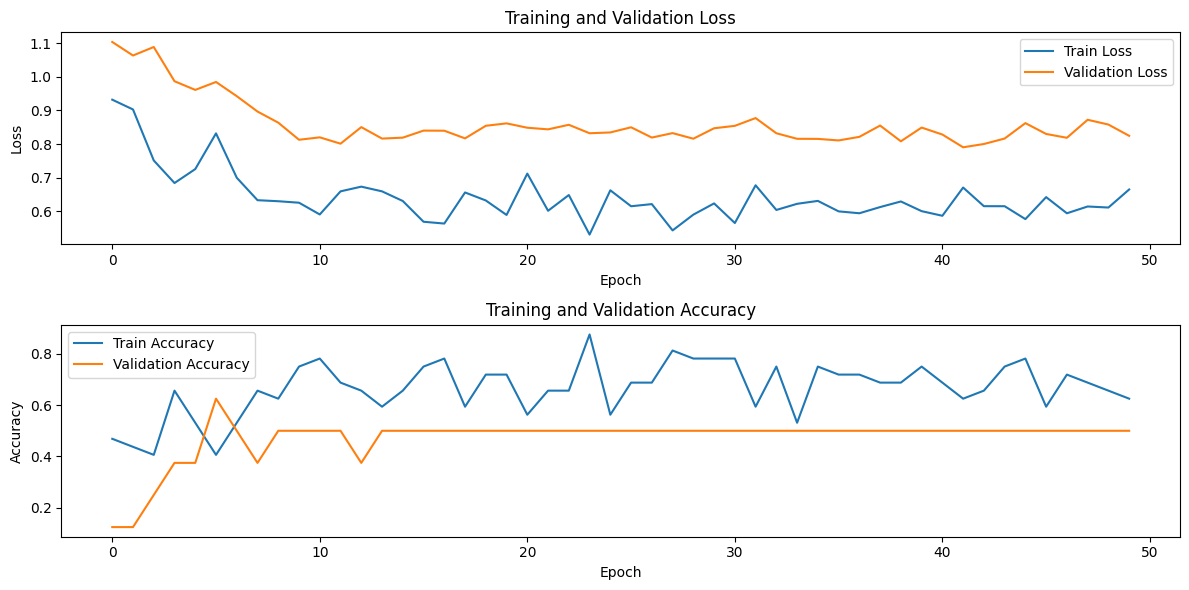

In [ ]:
train_loss, val_loss, train_acc, val_acc = train_model(model2, loss, optimizer, scheduler, num_epochs=50);

## Проверяем на тестовой выборке

In [ ]:
test_dataset = ImageFolderWithPaths('test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

**Задание**: Вычислите финальную точность сети на обучающем наборе данных

In [ ]:
get_acc(model2, val_dataloader)

100%|██████████| 4/4 [00:00<00:00, 20.12it/s]

Финальная точность сети на обучающем наборе данных: 50.00%


In [ ]:
test_predictions, test_img_paths = get_pred(model2, test_dataloader)

100%|██████████| 372/372 [00:07<00:00, 49.24it/s]


In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

In [ ]:
submission_df2 = create_sub(test_img_paths, test_predictions, 'bad_rn_submission')
submission_df2.head()

<ipython-input-28-7b759809f8b5>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_df['id'] = submission_df['id'].str.replace('.jpg', '')


label
id           
0000    dirty
0001    dirty
0002  cleaned
0003    dirty
0004    dirty

In [ ]:
!kaggle competitions submit -c platesv2 -f bad_rn_submission.csv -m "Message"

100% 8.29k/8.29k [00:00<00:00, 34.1kB/s]
Successfully submitted to Cleaned vs Dirty V2

**Задание**: Напишите здесь, какая у вас получилась точность на тесте - **0.67876**  

Пока точность не 100% еще есть куда стремиться, но что же можно еще сделать?

Попробуем увеличить нашу обучающую выборку.

# **Сеть ResNet18 с применением трансферного обучения и аугментацией данных**

Чем больше разных данных нейронная сеть получит во время обучения, тем, в теории, лучше она будет работать на данных которые она никогда раньше не видела.

Аугментация данных — это важный этап обучения моделей машинного обучения. Под аугментацией данных понимается увеличение выборки данных для обучения через модификацию существующих данных. Использование методов аугментации данных показало себя хорошо на задаче классификации изображений.

Существует множество способов аугментации изображений:

  *   Отображение по вертикали или горизонтали (англ. flipping).
  *   Поворот изображения на определенный угол (англ. rotation).
  *   Создание отступа (англ. padding).
  *   Вырезание части изображения (англ. cropping).
  *   Добавление шума (англ. adding noise).
  *   Манипуляции с цветом (англ. color jittering).
  *   и т.д.

О аугментациях, которые реализованы в библиотеке PyTorch и, которые были применены в данной задаче можно почиатть по ссылке: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

Аугментация позволяет решить сразу две проблемы:


1.   Аугментация позволяет увеличить размер обучающего набора данных
2.   Позволяет уменьшить вероятность переобучения модели (когда модель показывает высокую точность на обучающей выборке, но на тестовой выборке точно значительно ниже)





## Подготовка датасета

Создаем загрузчики изображений, которые автоматически будут применять аугментации с данным в разных комбинациях.

**Задание**: Создайте итератор для получения изображение из папки с валидационными изображениями.

In [ ]:
train_transforms = [
    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.RandomOrder([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
        ]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

    transforms.Compose([
    transforms.RandomRotation(45),
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.RandomGrayscale(p=1),
    transforms.RandomOrder([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
        ]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.4, saturation=0.4, hue=0.4),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
]

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torch.utils.data.ConcatDataset([
    torchvision.datasets.ImageFolder(train_dir, train_transform)
    for train_transform in train_transforms])

############################### ошибка в val_dataset: почему применяем train_transform, а не val_transform? при замене немного просела метрика ##############################
# val_dataset = torch.utils.data.ConcatDataset([
#     torchvision.datasets.ImageFolder(val_dir, train_transform)
#     for train_transform in train_transforms])

val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transform)

batch_size = 2

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

**Задание**: Выведите все изображения первого батча.

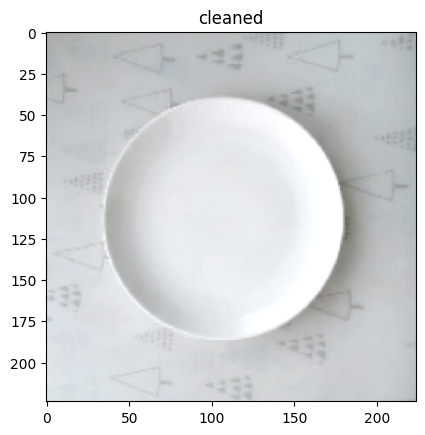

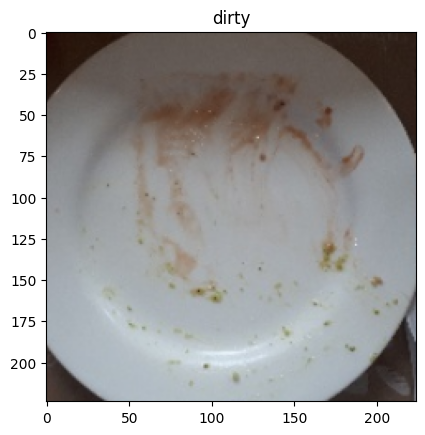

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, True, title=class_names[y_item])

## Подготовка предобученное модели ResNet18

**Задание**: Отключите обучение для всех слоев ResNet, кроме последнего и полносвязного слоев.

**Задание**: Определите функцию потерь и оптимизатор

In [ ]:
model3 = models.resnet18(pretrained=True)

# Замораживание всех слоев, кроме последнего и полносвязного слоя
for param in model3.parameters():
    param.requires_grad = False

# Размораживание последнего и полносвязного слоев
for param in model3.layer4.parameters():
    param.requires_grad = True

for param in model3.fc.parameters():
    param.requires_grad = True

model3.fc = torch.nn.Linear(model3.fc.in_features, 2)

model3 = model3.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=1.0e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Проверка

In [ ]:
num_params = sum(p.numel() for p in model3.parameters() if p.requires_grad)
assert(num_params == 8394754)

## Обучение

Epoch 0/49:


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 112/112 [00:01<00:00, 58.80it/s]

train Loss: 0.7530 Acc: 0.6830



100%|██████████| 4/4 [00:00<00:00, 19.64it/s]

val Loss: 0.6836 Acc: 0.5000
Epoch 1/49:



100%|██████████| 112/112 [00:01<00:00, 61.09it/s]

train Loss: 0.5030 Acc: 0.7455



100%|██████████| 4/4 [00:00<00:00, 19.92it/s]

val Loss: 1.3471 Acc: 0.5000
Epoch 2/49:



100%|██████████| 112/112 [00:01<00:00, 60.39it/s]

train Loss: 0.4537 Acc: 0.7679



100%|██████████| 4/4 [00:00<00:00, 19.98it/s]

val Loss: 0.8341 Acc: 0.6250
Epoch 3/49:



100%|██████████| 112/112 [00:02<00:00, 48.21it/s]

train Loss: 0.3649 Acc: 0.8661



100%|██████████| 4/4 [00:00<00:00, 11.99it/s]

val Loss: 0.8491 Acc: 0.6250
Epoch 4/49:



100%|██████████| 112/112 [00:02<00:00, 39.96it/s]

train Loss: 0.2232 Acc: 0.9196



100%|██████████| 4/4 [00:00<00:00, 19.61it/s]

val Loss: 0.7495 Acc: 0.7500
Epoch 5/49:



100%|██████████| 112/112 [00:01<00:00, 59.71it/s]

train Loss: 0.1342 Acc: 0.9509



100%|██████████| 4/4 [00:00<00:00, 18.23it/s]

val Loss: 1.1759 Acc: 0.5000
Epoch 6/49:



100%|██████████| 112/112 [00:01<00:00, 60.85it/s]

train Loss: 0.0782 Acc: 0.9732



100%|██████████| 4/4 [00:00<00:00, 19.62it/s]

val Loss: 0.7524 Acc: 0.6250
Epoch 7/49:



100%|██████████| 112/112 [00:01<00:00, 60.12it/s]

train Loss: 0.0452 Acc: 0.9955



100%|██████████| 4/4 [00:00<00:00, 19.76it/s]

val Loss: 0.8657 Acc: 0.6250
Epoch 8/49:



100%|██████████| 112/112 [00:01<00:00, 61.33it/s]

train Loss: 0.0400 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 20.44it/s]

val Loss: 0.8697 Acc: 0.6250


Epoch 9/49:


100%|██████████| 112/112 [00:02<00:00, 44.02it/s]

train Loss: 0.0330 Acc: 0.9955



100%|██████████| 4/4 [00:00<00:00, 12.59it/s]

val Loss: 0.9872 Acc: 0.5000
Epoch 10/49:



100%|██████████| 112/112 [00:02<00:00, 42.50it/s]

train Loss: 0.0238 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.80it/s]

val Loss: 0.9368 Acc: 0.6250
Epoch 11/49:



100%|██████████| 112/112 [00:01<00:00, 60.81it/s]

train Loss: 0.0218 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.15it/s]

val Loss: 1.0140 Acc: 0.6250
Epoch 12/49:



100%|██████████| 112/112 [00:01<00:00, 59.76it/s]

train Loss: 0.0213 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 18.62it/s]

val Loss: 1.0057 Acc: 0.6250
Epoch 13/49:



100%|██████████| 112/112 [00:01<00:00, 58.51it/s]

train Loss: 0.0158 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 18.74it/s]

val Loss: 1.0345 Acc: 0.6250
Epoch 14/49:



100%|██████████| 112/112 [00:01<00:00, 59.91it/s]

train Loss: 0.0234 Acc: 0.9955



100%|██████████| 4/4 [00:00<00:00, 18.98it/s]

val Loss: 0.9199 Acc: 0.6250
Epoch 15/49:



100%|██████████| 112/112 [00:02<00:00, 40.93it/s]

train Loss: 0.0182 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 12.39it/s]

val Loss: 0.9652 Acc: 0.6250
Epoch 16/49:



100%|██████████| 112/112 [00:02<00:00, 44.72it/s]

train Loss: 0.0186 Acc: 0.9955



100%|██████████| 4/4 [00:00<00:00, 18.06it/s]

val Loss: 1.1287 Acc: 0.5000
Epoch 17/49:



100%|██████████| 112/112 [00:01<00:00, 60.54it/s]

train Loss: 0.0154 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.66it/s]

val Loss: 0.9254 Acc: 0.6250
Epoch 18/49:



100%|██████████| 112/112 [00:01<00:00, 59.67it/s]

train Loss: 0.0161 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.28it/s]

val Loss: 0.9179 Acc: 0.6250
Epoch 19/49:



100%|██████████| 112/112 [00:01<00:00, 60.51it/s]

train Loss: 0.0318 Acc: 0.9955



100%|██████████| 4/4 [00:00<00:00, 20.04it/s]

val Loss: 1.0251 Acc: 0.6250
Epoch 20/49:



100%|██████████| 112/112 [00:01<00:00, 58.74it/s]

train Loss: 0.0154 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.96it/s]

val Loss: 0.9599 Acc: 0.6250
Epoch 21/49:



100%|██████████| 112/112 [00:02<00:00, 39.16it/s]

train Loss: 0.0130 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 11.92it/s]

val Loss: 0.9659 Acc: 0.6250
Epoch 22/49:



100%|██████████| 112/112 [00:02<00:00, 47.49it/s]

train Loss: 0.0196 Acc: 0.9955



100%|██████████| 4/4 [00:00<00:00, 19.37it/s]

val Loss: 0.9397 Acc: 0.6250
Epoch 23/49:



100%|██████████| 112/112 [00:01<00:00, 60.36it/s]

train Loss: 0.0150 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.80it/s]

val Loss: 0.9644 Acc: 0.6250
Epoch 24/49:



100%|██████████| 112/112 [00:01<00:00, 61.01it/s]

train Loss: 0.0153 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.92it/s]

val Loss: 1.0373 Acc: 0.6250
Epoch 25/49:



100%|██████████| 112/112 [00:01<00:00, 60.38it/s]

train Loss: 0.0155 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.43it/s]

val Loss: 1.0296 Acc: 0.6250
Epoch 26/49:



100%|██████████| 112/112 [00:01<00:00, 60.64it/s]

train Loss: 0.0147 Acc: 0.9955



100%|██████████| 4/4 [00:00<00:00, 20.00it/s]

val Loss: 1.0661 Acc: 0.5000
Epoch 27/49:



100%|██████████| 112/112 [00:02<00:00, 38.57it/s]

train Loss: 0.0139 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 12.29it/s]

val Loss: 0.9976 Acc: 0.6250
Epoch 28/49:



100%|██████████| 112/112 [00:02<00:00, 47.00it/s]

train Loss: 0.0152 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.80it/s]

val Loss: 1.0127 Acc: 0.6250
Epoch 29/49:



100%|██████████| 112/112 [00:01<00:00, 60.80it/s]

train Loss: 0.0158 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 18.52it/s]

val Loss: 1.0284 Acc: 0.6250
Epoch 30/49:



100%|██████████| 112/112 [00:01<00:00, 60.63it/s]

train Loss: 0.0217 Acc: 0.9911



100%|██████████| 4/4 [00:00<00:00, 19.60it/s]

val Loss: 1.0937 Acc: 0.6250
Epoch 31/49:



100%|██████████| 112/112 [00:01<00:00, 59.62it/s]

train Loss: 0.0166 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.06it/s]

val Loss: 0.9864 Acc: 0.6250
Epoch 32/49:



100%|██████████| 112/112 [00:01<00:00, 60.31it/s]

train Loss: 0.0213 Acc: 0.9911



100%|██████████| 4/4 [00:00<00:00, 19.22it/s]

val Loss: 0.9819 Acc: 0.6250
Epoch 33/49:



100%|██████████| 112/112 [00:03<00:00, 36.92it/s]

train Loss: 0.0198 Acc: 0.9955



100%|██████████| 4/4 [00:00<00:00, 11.80it/s]

val Loss: 1.0012 Acc: 0.6250
Epoch 34/49:



100%|██████████| 112/112 [00:02<00:00, 48.44it/s]

train Loss: 0.0143 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 17.38it/s]

val Loss: 0.9000 Acc: 0.6250
Epoch 35/49:



100%|██████████| 112/112 [00:01<00:00, 60.63it/s]

train Loss: 0.0224 Acc: 0.9911



100%|██████████| 4/4 [00:00<00:00, 18.51it/s]

val Loss: 0.9385 Acc: 0.6250
Epoch 36/49:



100%|██████████| 112/112 [00:01<00:00, 60.75it/s]

train Loss: 0.0180 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 18.73it/s]

val Loss: 0.9600 Acc: 0.6250
Epoch 37/49:



100%|██████████| 112/112 [00:01<00:00, 60.74it/s]

train Loss: 0.0164 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 18.78it/s]

val Loss: 1.0473 Acc: 0.6250
Epoch 38/49:



100%|██████████| 112/112 [00:01<00:00, 60.40it/s]

train Loss: 0.0134 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 18.83it/s]

val Loss: 0.8124 Acc: 0.6250
Epoch 39/49:



100%|██████████| 112/112 [00:03<00:00, 37.15it/s]

train Loss: 0.0122 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 12.10it/s]

val Loss: 0.9601 Acc: 0.6250
Epoch 40/49:



100%|██████████| 112/112 [00:02<00:00, 48.85it/s]

train Loss: 0.0148 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.81it/s]

val Loss: 1.0241 Acc: 0.7500
Epoch 41/49:



100%|██████████| 112/112 [00:01<00:00, 60.68it/s]

train Loss: 0.0135 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.35it/s]

val Loss: 1.1646 Acc: 0.5000
Epoch 42/49:



100%|██████████| 112/112 [00:01<00:00, 59.82it/s]

train Loss: 0.0191 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 18.88it/s]

val Loss: 0.9301 Acc: 0.6250
Epoch 43/49:



100%|██████████| 112/112 [00:01<00:00, 60.71it/s]

train Loss: 0.0173 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.21it/s]

val Loss: 1.2232 Acc: 0.5000
Epoch 44/49:



100%|██████████| 112/112 [00:01<00:00, 58.53it/s]

train Loss: 0.0155 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 18.05it/s]

val Loss: 0.9885 Acc: 0.6250
Epoch 45/49:



100%|██████████| 112/112 [00:03<00:00, 34.05it/s]

train Loss: 0.0134 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 12.66it/s]

val Loss: 1.0884 Acc: 0.5000
Epoch 46/49:



100%|██████████| 112/112 [00:02<00:00, 52.00it/s]

train Loss: 0.0144 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.29it/s]

val Loss: 1.0387 Acc: 0.6250
Epoch 47/49:



100%|██████████| 112/112 [00:01<00:00, 58.26it/s]

train Loss: 0.0148 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 18.50it/s]

val Loss: 1.1966 Acc: 0.5000
Epoch 48/49:



100%|██████████| 112/112 [00:01<00:00, 58.73it/s]

train Loss: 0.0146 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 18.40it/s]

val Loss: 1.0432 Acc: 0.6250
Epoch 49/49:



100%|██████████| 112/112 [00:01<00:00, 59.46it/s]

train Loss: 0.0184 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 18.49it/s]

val Loss: 0.9950 Acc: 0.6250


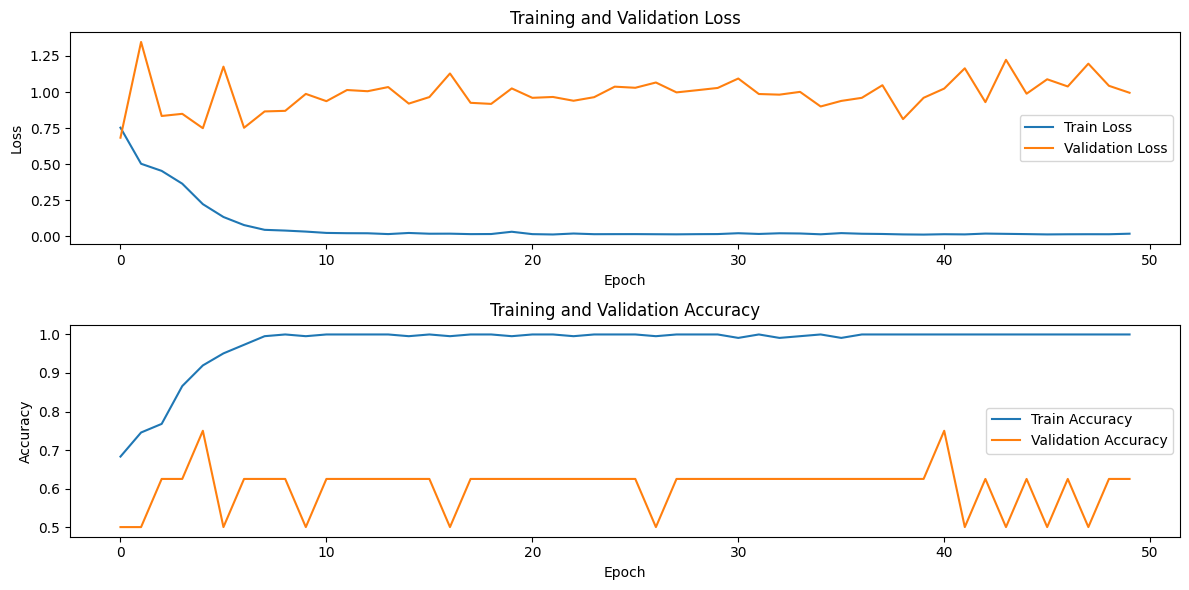

In [ ]:
train_loss, val_loss, train_acc, val_acc = train_model(model3, loss, optimizer, scheduler, num_epochs=50);

## Проверяем на тестовой выборке

**Задание**: Получите значение точности на обучающей выборке (не забудьте переопределить загрузчик изображений, чтобы не применять аугментации при вычислении финальной точности)

In [ ]:
get_acc(model3, val_dataloader)

100%|██████████| 4/4 [00:00<00:00, 19.15it/s]

Финальная точность сети на обучающем наборе данных: 62.50%


In [ ]:
test_dataset = ImageFolderWithPaths('test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
  test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
test_predictions, test_img_paths = get_pred(model3, test_dataloader)

100%|██████████| 372/372 [00:05<00:00, 71.74it/s]


In [ ]:
submission_df3 = create_sub(test_img_paths, test_predictions, 'bad_2_rn_submission')
submission_df3.head()

<ipython-input-9-7b759809f8b5>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_df['id'] = submission_df['id'].str.replace('.jpg', '')


label
id           
0000    dirty
0001    dirty
0002  cleaned
0003    dirty
0004  cleaned

In [ ]:
!kaggle competitions submit -c platesv2 -f bad_2_rn_submission.csv -m "Message"

100% 8.66k/8.66k [00:01<00:00, 4.49kB/s]
Successfully submitted to Cleaned vs Dirty V2

**Задание**: Напишите здесь, какая у вас получилась точность на тесте - **0.89516**

# Трансформации с kaggle 0.94758

In [ ]:
train_transforms_3 = [
    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.RandomOrder([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
        ]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

    transforms.Compose([
    transforms.RandomRotation(45),
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.RandomGrayscale(p=1),
    transforms.RandomOrder([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
        ]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.4, saturation=0.4, hue=0.4),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
]

val_transforms_3 = transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224, 224)),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torch.utils.data.ConcatDataset([
    torchvision.datasets.ImageFolder(train_dir, train_transform)
    for train_transform in train_transforms_3])

val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms_3)

batch_size = 2

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

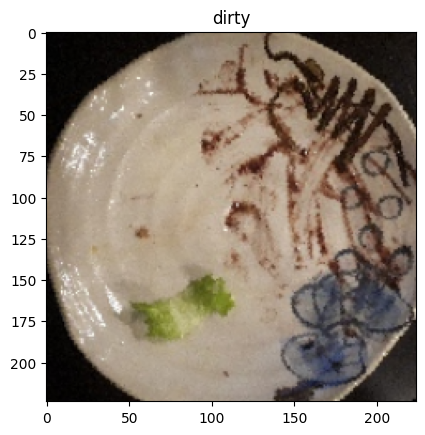

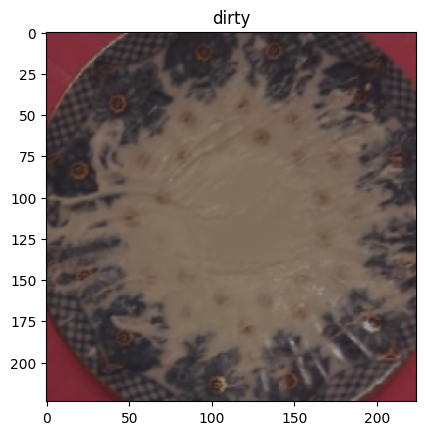

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, True, title=class_names[y_item])

Epoch 0/49:


100%|██████████| 112/112 [00:01<00:00, 60.91it/s]

train Loss: 0.0138 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 20.00it/s]

val Loss: 0.7734 Acc: 0.6250
Epoch 1/49:



100%|██████████| 112/112 [00:01<00:00, 56.96it/s]

train Loss: 0.0164 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 11.85it/s]

val Loss: 0.8122 Acc: 0.6250
Epoch 2/49:



100%|██████████| 112/112 [00:03<00:00, 36.62it/s]

train Loss: 0.0161 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 17.23it/s]

val Loss: 0.8006 Acc: 0.6250
Epoch 3/49:



100%|██████████| 112/112 [00:01<00:00, 60.13it/s]

train Loss: 0.0292 Acc: 0.9955



100%|██████████| 4/4 [00:00<00:00, 19.40it/s]

val Loss: 0.7776 Acc: 0.6250
Epoch 4/49:



100%|██████████| 112/112 [00:01<00:00, 61.03it/s]

train Loss: 0.0235 Acc: 0.9955



100%|██████████| 4/4 [00:00<00:00, 19.36it/s]

val Loss: 0.7612 Acc: 0.6250
Epoch 5/49:



100%|██████████| 112/112 [00:01<00:00, 58.19it/s]

train Loss: 0.0156 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.22it/s]

val Loss: 0.8113 Acc: 0.6250
Epoch 6/49:



100%|██████████| 112/112 [00:01<00:00, 61.50it/s]

train Loss: 0.0173 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 20.52it/s]

val Loss: 0.7181 Acc: 0.6250
Epoch 7/49:



100%|██████████| 112/112 [00:02<00:00, 52.63it/s]

train Loss: 0.0148 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00,  7.27it/s]

val Loss: 0.7865 Acc: 0.6250
Epoch 8/49:



100%|██████████| 112/112 [00:03<00:00, 30.78it/s]

train Loss: 0.0282 Acc: 0.9911



100%|██████████| 4/4 [00:00<00:00, 20.02it/s]

val Loss: 0.7841 Acc: 0.6250
Epoch 9/49:



100%|██████████| 112/112 [00:01<00:00, 60.54it/s]

train Loss: 0.0176 Acc: 0.9955



100%|██████████| 4/4 [00:00<00:00, 19.88it/s]

val Loss: 0.8149 Acc: 0.6250
Epoch 10/49:



100%|██████████| 112/112 [00:01<00:00, 61.90it/s]

train Loss: 0.0161 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.65it/s]

val Loss: 0.7898 Acc: 0.6250
Epoch 11/49:



100%|██████████| 112/112 [00:01<00:00, 62.30it/s]

train Loss: 0.0151 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 20.17it/s]

val Loss: 0.7939 Acc: 0.6250
Epoch 12/49:



100%|██████████| 112/112 [00:01<00:00, 62.43it/s]

train Loss: 0.0166 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.73it/s]

val Loss: 0.8070 Acc: 0.6250
Epoch 13/49:



100%|██████████| 112/112 [00:02<00:00, 45.82it/s]

train Loss: 0.0252 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 11.67it/s]

val Loss: 0.8183 Acc: 0.6250
Epoch 14/49:



100%|██████████| 112/112 [00:02<00:00, 42.64it/s]

train Loss: 0.0106 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.58it/s]

val Loss: 0.7913 Acc: 0.6250
Epoch 15/49:



100%|██████████| 112/112 [00:01<00:00, 62.19it/s]

train Loss: 0.0121 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.78it/s]

val Loss: 0.7560 Acc: 0.6250
Epoch 16/49:



100%|██████████| 112/112 [00:01<00:00, 62.79it/s]

train Loss: 0.0256 Acc: 0.9911



100%|██████████| 4/4 [00:00<00:00, 19.10it/s]

val Loss: 0.8065 Acc: 0.6250
Epoch 17/49:



100%|██████████| 112/112 [00:01<00:00, 62.32it/s]

train Loss: 0.0127 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.22it/s]

val Loss: 0.8169 Acc: 0.6250
Epoch 18/49:



100%|██████████| 112/112 [00:01<00:00, 58.45it/s]

train Loss: 0.0321 Acc: 0.9866



100%|██████████| 4/4 [00:00<00:00, 16.53it/s]

val Loss: 0.7574 Acc: 0.6250
Epoch 19/49:



100%|██████████| 112/112 [00:05<00:00, 22.33it/s]

train Loss: 0.0157 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00,  8.92it/s]

val Loss: 0.7967 Acc: 0.6250
Epoch 20/49:



100%|██████████| 112/112 [00:02<00:00, 54.17it/s]

train Loss: 0.0148 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 18.48it/s]

val Loss: 0.7733 Acc: 0.6250
Epoch 21/49:



100%|██████████| 112/112 [00:01<00:00, 62.46it/s]

train Loss: 0.0123 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 18.94it/s]

val Loss: 0.7549 Acc: 0.6250
Epoch 22/49:



100%|██████████| 112/112 [00:02<00:00, 38.40it/s]

train Loss: 0.0139 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00,  9.40it/s]

val Loss: 0.7814 Acc: 0.6250
Epoch 23/49:



100%|██████████| 112/112 [00:05<00:00, 21.97it/s]

train Loss: 0.0184 Acc: 0.9955



100%|██████████| 4/4 [00:00<00:00,  5.05it/s]

val Loss: 0.7751 Acc: 0.6250
Epoch 24/49:



100%|██████████| 112/112 [00:03<00:00, 34.75it/s]

train Loss: 0.0123 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.57it/s]

val Loss: 0.7421 Acc: 0.6250
Epoch 25/49:



100%|██████████| 112/112 [00:01<00:00, 61.24it/s]

train Loss: 0.0171 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.69it/s]

val Loss: 0.7566 Acc: 0.6250
Epoch 26/49:



100%|██████████| 112/112 [00:01<00:00, 62.00it/s]

train Loss: 0.0226 Acc: 0.9955



100%|██████████| 4/4 [00:00<00:00, 19.65it/s]

val Loss: 0.7692 Acc: 0.6250
Epoch 27/49:



100%|██████████| 112/112 [00:01<00:00, 60.68it/s]

train Loss: 0.0137 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 18.46it/s]

val Loss: 0.7847 Acc: 0.6250
Epoch 28/49:



100%|██████████| 112/112 [00:02<00:00, 46.89it/s]

train Loss: 0.0160 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 12.10it/s]

val Loss: 0.7431 Acc: 0.6250
Epoch 29/49:



100%|██████████| 112/112 [00:02<00:00, 41.43it/s]

train Loss: 0.0188 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.51it/s]

val Loss: 0.7878 Acc: 0.6250
Epoch 30/49:



100%|██████████| 112/112 [00:01<00:00, 62.35it/s]

train Loss: 0.0163 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.89it/s]

val Loss: 0.7674 Acc: 0.6250
Epoch 31/49:



100%|██████████| 112/112 [00:01<00:00, 62.62it/s]

train Loss: 0.0155 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 20.28it/s]

val Loss: 0.7449 Acc: 0.6250


Epoch 32/49:


100%|██████████| 112/112 [00:01<00:00, 62.22it/s]

train Loss: 0.0194 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.35it/s]

val Loss: 0.7645 Acc: 0.6250
Epoch 33/49:



100%|██████████| 112/112 [00:01<00:00, 61.87it/s]

train Loss: 0.0180 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 18.62it/s]

val Loss: 0.7750 Acc: 0.6250
Epoch 34/49:



100%|██████████| 112/112 [00:02<00:00, 43.93it/s]

train Loss: 0.0165 Acc: 0.9955



100%|██████████| 4/4 [00:00<00:00, 12.70it/s]

val Loss: 0.7437 Acc: 0.6250
Epoch 35/49:



100%|██████████| 112/112 [00:02<00:00, 40.15it/s]

train Loss: 0.0130 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.69it/s]

val Loss: 0.8070 Acc: 0.6250
Epoch 36/49:



100%|██████████| 112/112 [00:01<00:00, 62.47it/s]

train Loss: 0.0127 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.56it/s]

val Loss: 0.7687 Acc: 0.6250
Epoch 37/49:



100%|██████████| 112/112 [00:01<00:00, 61.66it/s]

train Loss: 0.0176 Acc: 0.9955



100%|██████████| 4/4 [00:00<00:00, 19.81it/s]

val Loss: 0.8223 Acc: 0.6250
Epoch 38/49:



100%|██████████| 112/112 [00:01<00:00, 61.10it/s]

train Loss: 0.0164 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.85it/s]

val Loss: 0.8255 Acc: 0.6250
Epoch 39/49:



100%|██████████| 112/112 [00:01<00:00, 62.27it/s]

train Loss: 0.0169 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 18.83it/s]

val Loss: 0.7412 Acc: 0.6250
Epoch 40/49:



100%|██████████| 112/112 [00:02<00:00, 49.81it/s]

train Loss: 0.0157 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 12.89it/s]

val Loss: 0.7956 Acc: 0.6250
Epoch 41/49:



100%|██████████| 112/112 [00:02<00:00, 38.84it/s]

train Loss: 0.0328 Acc: 0.9866



100%|██████████| 4/4 [00:00<00:00, 18.67it/s]

val Loss: 0.8262 Acc: 0.6250
Epoch 42/49:



100%|██████████| 112/112 [00:01<00:00, 62.15it/s]

train Loss: 0.0203 Acc: 0.9955



100%|██████████| 4/4 [00:00<00:00, 18.20it/s]

val Loss: 0.7788 Acc: 0.6250
Epoch 43/49:



100%|██████████| 112/112 [00:01<00:00, 62.27it/s]

train Loss: 0.0206 Acc: 0.9955



100%|██████████| 4/4 [00:00<00:00, 18.99it/s]

val Loss: 0.8566 Acc: 0.6250
Epoch 44/49:



100%|██████████| 112/112 [00:01<00:00, 63.45it/s]

train Loss: 0.0115 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.17it/s]

val Loss: 0.7808 Acc: 0.6250
Epoch 45/49:



100%|██████████| 112/112 [00:01<00:00, 60.49it/s]

train Loss: 0.0171 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.58it/s]

val Loss: 0.7868 Acc: 0.6250
Epoch 46/49:



100%|██████████| 112/112 [00:02<00:00, 53.22it/s]

train Loss: 0.0168 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 12.51it/s]

val Loss: 0.7604 Acc: 0.6250
Epoch 47/49:



100%|██████████| 112/112 [00:02<00:00, 38.53it/s]

train Loss: 0.0165 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.69it/s]

val Loss: 0.7432 Acc: 0.6250
Epoch 48/49:



100%|██████████| 112/112 [00:01<00:00, 61.67it/s]

train Loss: 0.0163 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 19.60it/s]

val Loss: 0.7402 Acc: 0.6250
Epoch 49/49:



100%|██████████| 112/112 [00:01<00:00, 60.98it/s]

train Loss: 0.0188 Acc: 1.0000



100%|██████████| 4/4 [00:00<00:00, 18.80it/s]

val Loss: 0.8464 Acc: 0.6250


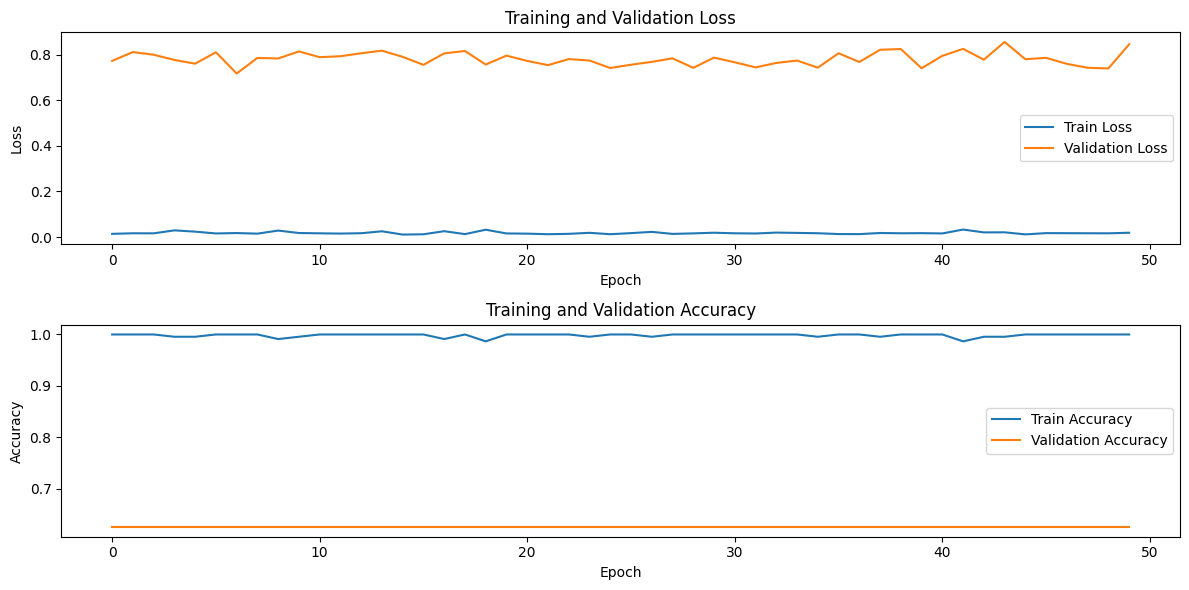

In [ ]:
train_loss, val_loss, train_acc, val_acc = train_model(model3, loss, optimizer, scheduler, num_epochs=50);

In [ ]:
get_acc(model3, val_dataloader)

100%|██████████| 4/4 [00:00<00:00, 19.01it/s]

Финальная точность сети на обучающем наборе данных: 62.50%


In [ ]:
test_dataset = ImageFolderWithPaths('test', val_transforms_3)

test_dataloader = torch.utils.data.DataLoader(
  test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
test_predictions, test_img_paths = get_pred(model3, test_dataloader)

100%|██████████| 372/372 [00:03<00:00, 104.85it/s]


In [ ]:
submission_df4 = create_sub(test_img_paths, test_predictions, 'bad_2_rn_submission')
submission_df4.head()

<ipython-input-9-7b759809f8b5>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_df['id'] = submission_df['id'].str.replace('.jpg', '')


label
id         
0000  dirty
0001  dirty
0002  dirty
0003  dirty
0004  dirty

In [ ]:
!kaggle competitions submit -c platesv2 -f bad_2_rn_submission.csv -m "Message"

100% 8.52k/8.52k [00:01<00:00, 4.92kB/s]
Successfully submitted to Cleaned vs Dirty V2

# 0.94758

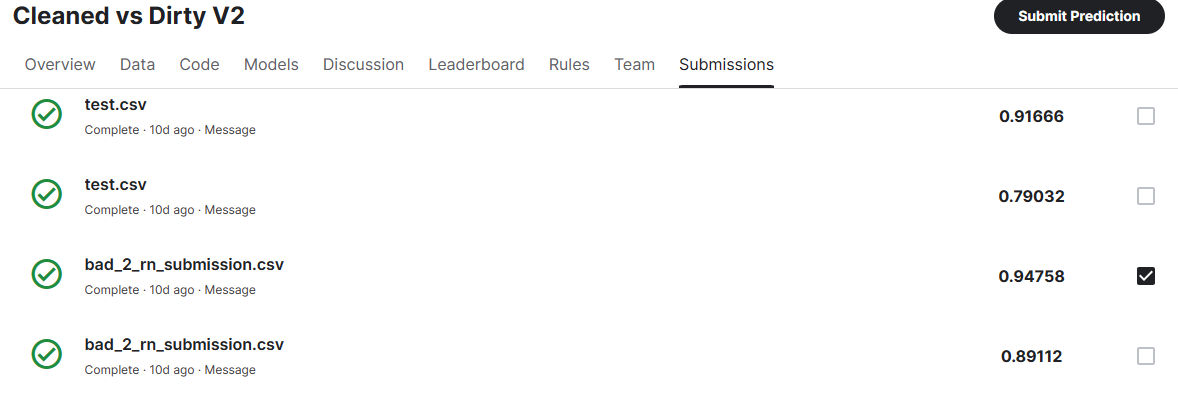